In [13]:
import pickle
from scipy.stats.mstats import gmean
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats.mstats import gmean
import xgboost as xgb
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files"

In [14]:
df = pd.read_stata(fpath + "/full_data_truncated.dta")

In [15]:
df.loc[:,'first_gen_0'] = df.phe_1 + df.phe_2 + df.phe_3
df.loc[:,'first_gen_1'] = df.phe_4 + df.phe_5 + df.phe_6 + df.phe_7

In [16]:
for v in ['term_cred_att_', 'enrolled_', 'available_']:
    df.loc[:,v+"sum"] = 0
    for t1 in ['sp','su','fa']:
        for t2 in range(1,7):
            t = t1+str(t2)
            df.loc[:,v+"sum"] = df.loc[:,v+"sum"] + df.loc[:,v+t]
df.loc[:,'avg_cred_att'] = df.term_cred_att_sum / df.enrolled_sum
df.loc[:,'pct_enrolled'] = df.enrolled_sum / df.available_sum

##### **Note: This model variant only includes 14 predictors, which are all simple non-term-specific predictors

In [17]:
predictors = ['male', 'afam', 'white', 'hisp', 'other', 'first_gen_0', 'first_gen_1', 'cum_gpa', 'pct_enrolled', 'avg_cred_att', 'available_sum', 'prop_comp', 'pell_0_ind', 'pell_1_ind']
print(len(predictors))
impute_list_3 = set(["cum_gpa", "prop_comp"])

14


In [18]:
train_df = df[df.valid == 0]
test_df = df[df.valid == 1]
print(train_df.shape,test_df.shape)

(298139, 348) (33115, 348)


In [19]:
def impute(train, test):
    for p in impute_list_3:
        avg_p = np.nanmean(train[p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    return train, test     

In [20]:
train_df_new, test_df_new = impute(train_df, test_df)
X_train = train_df_new.loc[:,predictors]
y_train = train_df_new.grad_6years
X_test = test_df_new.loc[:,predictors]
y_test = test_df_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [22]:
np.random.seed(4321)
val_indices = np.random.choice(train_df.shape[0], int(np.floor(train_df.shape[0]*0.15)), replace=False)
train_val = train_df.iloc[val_indices,:]
train_train = train_df.iloc[np.setdiff1d(np.arange(train_df.shape[0]), val_indices),:]
train_train_new, train_val_new = impute(train_train, train_val)
X_train_train = train_train_new.loc[:,predictors]
y_train_train = train_train_new.grad_6years
X_train_val = train_val_new.loc[:,predictors]
y_train_val = train_val_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [23]:
dtrain_train = xgb.DMatrix(X_train_train, y_train_train)
dtrain_val = xgb.DMatrix(X_train_val, y_train_val)

In [24]:
results_dir = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_simple_predictors_2\\"

#### (1) Grid Search for max_depth and eta (learning rate)

In [14]:
grid_1 = [(md,e) for md in range(4,8) for e in [0.01, 0.02, 0.05, 0.1, 0.2]]
validation_auc_1 = Counter()
for md,e in grid_1:
    print("max_depth = {0}, eta = {1}:".format(md,e))
    params = {'max_depth': md, 'eta': e, 'min_child_weight': 1, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_1[(md,e)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 4, eta = 0.01:
[0]	validation-auc:0.7989
Will train until validation-auc hasn't improved in 10 rounds.
Stopping. Best iteration:
[34]	validation-auc:0.826419


max_depth = 4, eta = 0.02:
[0]	validation-auc:0.7989
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.82868
[100]	validation-auc:0.833961
[150]	validation-auc:0.837466
[200]	validation-auc:0.840389
[250]	validation-auc:0.84226
[300]	validation-auc:0.843518
[350]	validation-auc:0.844444
[400]	validation-auc:0.845196
[450]	validation-auc:0.845798
[500]	validation-auc:0.846274
[550]	validation-auc:0.846678
[600]	validation-auc:0.847041
[650]	validation-auc:0.847316
[700]	validation-auc:0.847583
[750]	validation-auc:0.847785
[800]	validation-auc:0.847968
[850]	validation-auc:0.848143
[900]	validation-auc:0.848295
[950]	validation-auc:0.848429
[1000]	validation-auc:0.848581
[1050]	validation-auc:0.848718
[1100]	validation-auc:0.848847
[1150]	validation-auc:0.848955
[1200]	validation-auc:

Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.845023
[100]	validation-auc:0.848321
[150]	validation-auc:0.849661
[200]	validation-auc:0.850203
[250]	validation-auc:0.850498
[300]	validation-auc:0.850603
Stopping. Best iteration:
[291]	validation-auc:0.85061


max_depth = 7, eta = 0.1:
[0]	validation-auc:0.817
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.848356
[100]	validation-auc:0.850107
Stopping. Best iteration:
[132]	validation-auc:0.850332


max_depth = 7, eta = 0.2:
[0]	validation-auc:0.817
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.849052
Stopping. Best iteration:
[58]	validation-auc:0.849311




In [15]:
for t in validation_auc_1.most_common():
    print(t)

((7, 0.05), 0.85061)
((7, 0.02), 0.850594)
((6, 0.02), 0.850519)
((7, 0.1), 0.850332)
((6, 0.01), 0.850296)
((5, 0.02), 0.850215)
((6, 0.05), 0.850059)
((6, 0.2), 0.850014)
((5, 0.05), 0.849914)
((5, 0.1), 0.849834)
((4, 0.02), 0.84971)
((4, 0.05), 0.849678)
((4, 0.1), 0.849677)
((6, 0.1), 0.849663)
((5, 0.2), 0.849565)
((4, 0.2), 0.849526)
((7, 0.2), 0.849311)
((7, 0.01), 0.83908)
((5, 0.01), 0.831223)
((4, 0.01), 0.826419)


#### (2) Grid Search for min_child_weight (along with max_depth)

In [16]:
md1 = 6
grid_2 = [(md1+i,mcw) for i in [-1,0,1] for mcw in [3,5]]
validation_auc_2 = Counter()
for md,mcw in grid_2:
    print("max_depth = {0}, min_child_weight = {1}:".format(md,mcw))
    params = {'max_depth': md, 'eta': 0.02, 'min_child_weight': mcw, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_2[(md,mcw)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 5, min_child_weight = 3:
[0]	validation-auc:0.806552
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.834017
[100]	validation-auc:0.838419
[150]	validation-auc:0.841474
[200]	validation-auc:0.843564
[250]	validation-auc:0.845046
[300]	validation-auc:0.845979
[350]	validation-auc:0.846674
[400]	validation-auc:0.847295
[450]	validation-auc:0.847786
[500]	validation-auc:0.848159
[550]	validation-auc:0.848454
[600]	validation-auc:0.848724
[650]	validation-auc:0.848941
[700]	validation-auc:0.84914
[750]	validation-auc:0.849297
[800]	validation-auc:0.849445
[850]	validation-auc:0.849594
[900]	validation-auc:0.849692
[950]	validation-auc:0.849777
[1000]	validation-auc:0.849856
[1050]	validation-auc:0.849944
Stopping. Best iteration:
[1057]	validation-auc:0.849962


max_depth = 5, min_child_weight = 5:
[0]	validation-auc:0.806552
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.834019
[100]	validation-auc:0.83841

In [17]:
for t in validation_auc_2.most_common():
    print(t)

((7, 5), 0.850697)
((7, 3), 0.850599)
((6, 5), 0.850472)
((6, 3), 0.850432)
((5, 3), 0.849962)
((5, 5), 0.849959)


#### (3) Grid Search for colsample_by_tree

In [18]:
grid_3 = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
validation_auc_3 = Counter()
for cbt in grid_3:
    print("colsample_by_tree = {}:".format(cbt))
    params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 5, 'colsample_bytree': cbt, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_3[cbt] = np.max(evals_result['validation']['auc'])
    print("")

colsample_by_tree = 0.5:
[0]	validation-auc:0.669135
Will train until validation-auc hasn't improved in 10 rounds.
Stopping. Best iteration:
[7]	validation-auc:0.83465


colsample_by_tree = 0.55:
[0]	validation-auc:0.669135
Will train until validation-auc hasn't improved in 10 rounds.
Stopping. Best iteration:
[7]	validation-auc:0.83465


colsample_by_tree = 0.6:
[0]	validation-auc:0.806231
Will train until validation-auc hasn't improved in 10 rounds.
Stopping. Best iteration:
[37]	validation-auc:0.840852


colsample_by_tree = 0.65:
[0]	validation-auc:0.806231
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.841683
[100]	validation-auc:0.843626
[150]	validation-auc:0.845728
[200]	validation-auc:0.84703
[250]	validation-auc:0.848265
[300]	validation-auc:0.849077
[350]	validation-auc:0.849593
[400]	validation-auc:0.8499
[450]	validation-auc:0.850143
[500]	validation-auc:0.850333
[550]	validation-auc:0.850465
[600]	validation-auc:0.850556
[650]	validatio

In [19]:
validation_auc_3.most_common()

[(0.7, 0.850754),
 (0.65, 0.850754),
 (0.85, 0.850697),
 (0.8, 0.850697),
 (0.9, 0.850653),
 (0.75, 0.850555),
 (0.6, 0.840852),
 (0.5, 0.83465),
 (0.55, 0.83465)]

#### (4) Finally select the opitmal num_boost_round

In [20]:
params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 5, 'colsample_bytree': 0.7, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
evals_result = {}
xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                      early_stopping_rounds = 10,
                      evals_result = evals_result,
                      verbose_eval = 50)
optimal_num_boost_round = np.argmax(evals_result['validation']['auc'])
print("")
print(optimal_num_boost_round)

[0]	validation-auc:0.806231
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.841683
[100]	validation-auc:0.843626
[150]	validation-auc:0.845728
[200]	validation-auc:0.84703
[250]	validation-auc:0.848265
[300]	validation-auc:0.849077
[350]	validation-auc:0.849593
[400]	validation-auc:0.8499
[450]	validation-auc:0.850143
[500]	validation-auc:0.850333
[550]	validation-auc:0.850465
[600]	validation-auc:0.850556
[650]	validation-auc:0.850621
[700]	validation-auc:0.850707
Stopping. Best iteration:
[737]	validation-auc:0.850754


737


#### (5) Train the final xgb model and make predictions for observations in the test set

In [21]:
optimal_num_boost_round = 737

In [22]:
# specify parameters via map
params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 5, 'colsample_bytree': 0.7, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
final_xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = optimal_num_boost_round)
# make prediction for observations in the test set
y_test_pred = final_xgb_model.predict(dtest)

In [23]:
print("XGBoost:")
print("AUC = {}".format(round(roc_auc_score(dtest.get_label(), y_test_pred), 4)))

XGBoost:
AUC = 0.855


In [24]:
# save the model object and predicted scores on the validation sample to local disk
# pickle.dump(final_xgb_model, open(results_dir + "/xgb.p", "wb"))
pickle.dump(list(y_test_pred), open(results_dir + "/y_test_pred_xgb.p", "wb"))

In [25]:
feature_importance = pd.DataFrame(list(final_xgb_model.get_fscore().items()), columns=['feature','importance']).sort_values('importance', ascending=False)
feature_importance.loc[:, 'importance'] = feature_importance.loc[:, 'importance'] / sum(feature_importance.loc[:, 'importance'])
yy = feature_importance.loc[:, 'importance'].iloc[:20]
xx = feature_importance.loc[:, 'feature'].iloc[:20]

In [26]:
xgb_summary = feature_importance.rename(columns = {'feature':'predictor_name',
                                                   'importance':'feature_importance'})\
.loc[:,['predictor_name', 'feature_importance']]
xgb_summary = xgb_summary.merge(pd.DataFrame({'predictor_name': predictors}), on=['predictor_name'], how='right')\
.sort_values(['feature_importance', 'predictor_name'], ascending=[False, True]).fillna(0)
xgb_summary.to_csv(results_dir + "xgb_summary.csv", index=False)

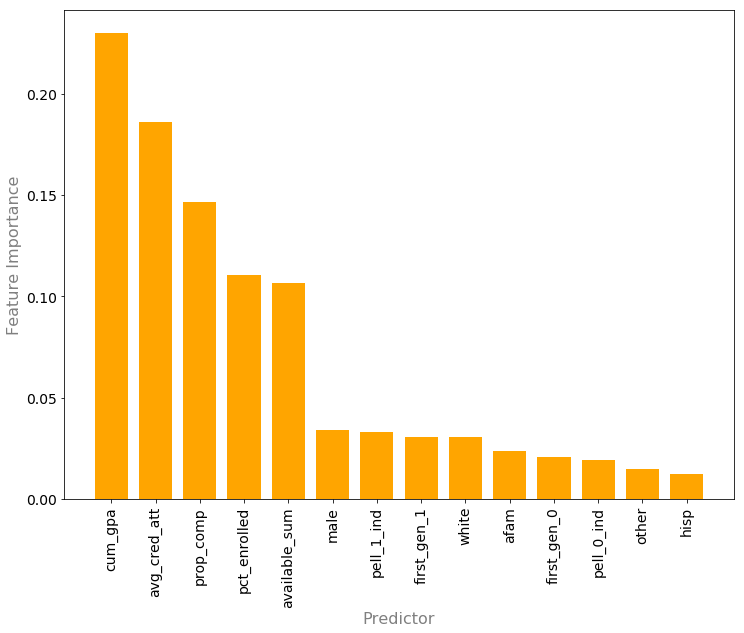

In [29]:
fig = plt.figure(figsize=(12,9))
plt.bar(list(range(14)), yy, width=0.75, color = "orange")
plt.xticks(list(range(14)), xx, rotation = 'vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Predictor", fontsize=16, color="gray")
plt.ylabel("Feature Importance", fontsize=16, color="gray")
plt.savefig(results_dir + "XGBoost_variable_importance.png")
plt.show()

In [30]:
def find_optimal_threshold(p,r,t):
    to_drop = np.union1d(np.where(pd.isnull(p[:-1]) == True)[0], np.where(pd.isnull(r[:-1]) == True)[0])
    to_drop = np.union1d(to_drop, np.where(pd.isnull(t) == True)[0])
    to_keep = np.setdiff1d(np.array(list(range(len(p)-1))), to_drop)
    p,r,t = p[to_keep],r[to_keep],t[to_keep]
    f1 = 2*p*r/(p+r)
    best_t = t[np.argmax(f1)]
    best_t
    return best_t

def cross_validation(train, xgb_params, nbr):
    threshold_list = []
    auc_list = []
    k_fold =  StratifiedKFold(n_splits = 10, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grad_6years):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        train_part_new, test_part_new = impute(train_part, test_part)
        X_1 = train_part_new.loc[:,predictors]
        y_1 = train_part_new.grad_6years
        X_2 = test_part_new.loc[:,predictors]
        y_2 = test_part_new.grad_6years
        dtrain_cv = xgb.DMatrix(X_1,y_1)
        dtest_cv = xgb.DMatrix(X_2,y_2)
        xgb_cv_model = xgb.train(params=xgb_params, dtrain=dtrain_cv, num_boost_round = nbr)
        y_2_pred = xgb_cv_model.predict(dtest_cv)
        p,r,t = precision_recall_curve(y_2, y_2_pred)
        auc = roc_auc_score(y_2, y_2_pred)
        threshold_list.append(find_optimal_threshold(p,r,t))
        auc_list.append(auc)
    print(np.mean(auc_list), np.std(auc_list, ddof=1))
    return gmean(threshold_list)

In [31]:
final_params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 5, 'colsample_bytree': 0.7, 
                'subsample': 0.8, 
                'objective': 'binary:logistic', 'eval_metric': ['auc'],
                'seed': 12345}
best_threshold = cross_validation(train_df, final_params, optimal_num_boost_round)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

0.8523419272699062 0.002535903987580834


In [32]:
best_threshold

0.34333235

In [34]:
def create_confusion_matrix(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_0','Pred_1'], index=['Real_0', 'Real_1'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score = {}".format(round(2*p1*r1/(p1+r1),4)))    
    cm_df.to_csv(results_dir + fname + ".csv")
    return p1,r1,p0,r0,round(2*p1*r1/(p1+r1),4)

In [35]:
print("F1 threshold = {}:\n".format(str(round(best_threshold,3))))
pr_xgb = create_confusion_matrix(y_test_pred, best_threshold, "XGBoost_cm1")

F1 threshold = 0.343:

         Pred_0   Pred_1         
Real_0  16963.0   4845.0  21808.0
Real_1   2592.0   8715.0  11307.0
        19555.0  13560.0  33115.0

F1 score = 0.7009


In [36]:
num_of_0 = int(round((1-np.mean(train_df.grad_6years))*len(y_test)))
y_test_pred_binary = np.ones(len(y_test))
y_test_pred_binary[np.argsort(y_test_pred)[:num_of_0]] = 0
alternative_threshold = y_test_pred[np.argsort(y_test_pred)[num_of_0]]
print("Alternative threshold = {}:\n".format(str(round(alternative_threshold,3))))
pr2_xgb = create_confusion_matrix(y_test_pred_binary, best_threshold, "XGBoost_cm2")

Alternative threshold = 0.416:

         Pred_0   Pred_1         
Real_0  18348.0   3460.0  21808.0
Real_1   3441.0   7866.0  11307.0
        21789.0  11326.0  33115.0

F1 score = 0.6951


In [37]:
precision_recall_df = pd.DataFrame([(best_threshold,)+pr_xgb,(alternative_threshold,)+pr2_xgb]).round(4)
precision_recall_df.index = ['F1','Same_Graduation_Rate']
precision_recall_df.columns = ['threshold','precision_1','recall_1','precision_0','recall_0','f1_score']
precision_recall_df.to_csv(results_dir + "XGBoost_precision_recall.csv", index=True)

#### Reorganize files of key evaluation metrics for the five truncated models: OLS, Logit, RF, XGBoost, CoxPH

In [2]:
# Extract all of the key evaluation metrics of the five truncated models that only include simple non-term-specific predictors,
# which will be used to populate column (2) within the Appendix Table A1 of the paper, as well as to generate Figure 1 and
# Figure A14
cstat = [0.8183,0.8105,0.8368,0.8516,0.855]
m_dict = {'Logit': 'LR1', 'OLS': 'OLS',
          'RF': 'RF', 'XGBoost': 'XGBoost',
          'CoxPH': 'Cox'}
m_list = ['Logit', 'OLS', 'CoxPH', 'RF', 'XGBoost']
summary = []
for c,m in zip(cstat,m_list):
    summary.append((m,c)+tuple(pd.read_csv(results_dir + "\\{}_precision_recall.csv".format(m_dict[m])).iloc[0,1:]))
summary_df = pd.DataFrame(summary, columns=['model','c-statistic','threshold','precision_1','recall_1',
                                            'precision_0','recall_0','f1_score_1'])
summary_df.loc[:,'f1_score_0'] = 2*summary_df.precision_0*summary_df.recall_0/(summary_df.precision_0+summary_df.recall_0)
summary_df.loc[:,'f1_score_0'] = summary_df.loc[:,'f1_score_0'].apply(lambda x: round(x,4))
summary_df.to_csv(results_dir + "cleaned_results\\main_eval_metrics.csv", index=False)